c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0115 - val_loss: 0.0027
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 9.5536e-04 - val_loss: 0.0023
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 8.6506e-04 - val_loss: 0.0016
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.0886e-04 - val_loss: 8.9155e-04
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.8297e-04 - val_loss: 0.0034
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.2952e-04 - val_loss: 0.0011
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.7387e-04 - val_loss: 8.7687e-04
Epoch 9/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 7.3062e-04 - val_loss: 7.0149e-04
Epoch 10/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 6.2117e-04 - val_loss: 7.6149e-04
Epoch 11/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 5.9990e-04 - val_lo

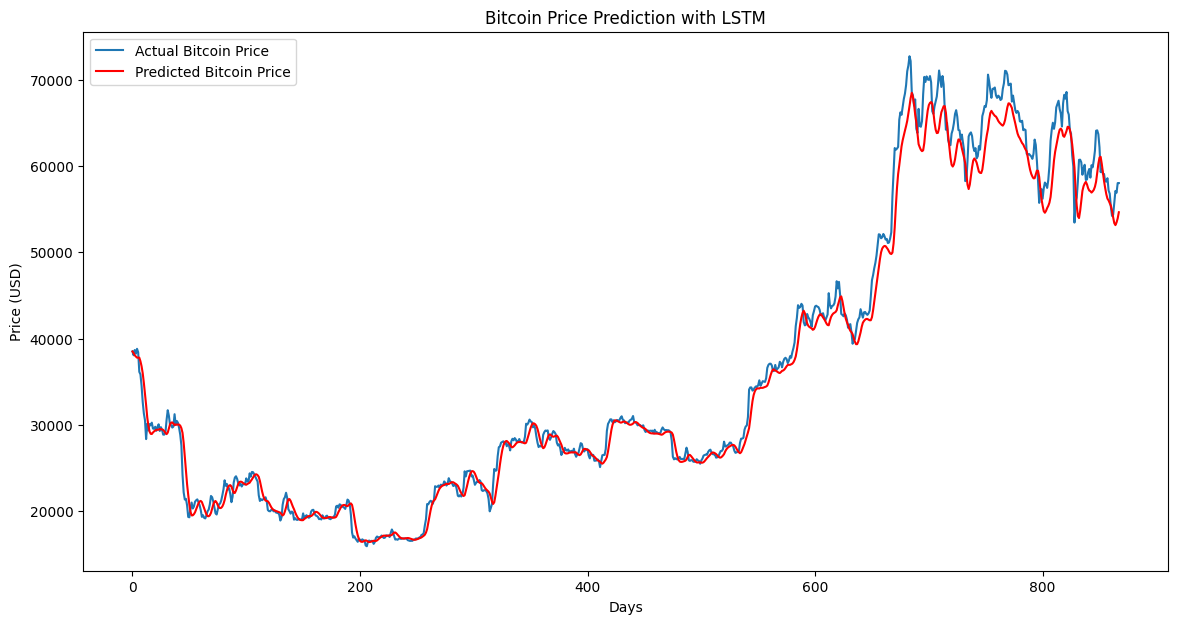

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Load the dataset
df = pd.read_csv('./btcusd_1-min_data.csv')

# Calculate the weighted price as the average of High, Low, and Close
if 'High' in df.columns and 'Low' in df.columns and 'Close' in df.columns:
    df['weighted_price'] = (df['High'] + df['Low'] + df['Close']) / 3
else:
    print("Required columns ('High', 'Low', 'Close') not found in the dataset.")

# Convert Timestamp to datetime and set it as the index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Resample to daily frequency and compute mean values
df_daily = df.resample('D').mean()

# Drop missing values
df_daily.dropna(inplace=True)

# Select the 'weighted_price' column for prediction
data = df_daily[['weighted_price']].values

# Normalize the data (LSTM performs better with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define a function to create a dataset for LSTM
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])  # Past 'look_back' values as input
        Y.append(dataset[i, 0])              # Current value as target
    return np.array(X), np.array(Y)

# Set the look_back period (e.g., 60 days)
look_back = 60

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

# Create datasets for LSTM
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape the data to [samples, time steps, features] for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout to avoid overfitting
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer for predicting the price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test))

# Make predictions on the test data
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)  # Inverse scaling

# Inverse transform the true prices as well
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(Y_test_actual, predicted_prices))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(Y_test_actual, label='Actual Bitcoin Price')
plt.plot(predicted_prices, label='Predicted Bitcoin Price', color='red')
plt.title('Bitcoin Price Prediction with LSTM')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
